<div style="padding:30px; color: white; background-color: #0071CD">
<center>
<img src="img/logoub.jpeg"></img>
<center>
<p>
<h1>Algorísmica Avançada</h1>
<h2>Pràctica 2.B - Dynamic Programming </h2>
</center>
</p>
</div>

En esta sesión de programación dinámica veremos únicamente un algoritmo de procesamiento de imágenes. En este notebook se incluyen muchos conceptos que puede que os suenen extraños a día de hoy, sobretodo si no se ha visto tratamiento de imágenes. Independientemente, la única parte del algoritmo que se os pide impementar es aquella que contiene de forma explicita la programación dinámica, así que solo nos hace falta ver la imágen como una matriz de valores y de esta forma podremos trabajar con ella sin demasiado problema.

## 0 Conceptos esenciales

1. __Imágen__: Aunque existen diversas representaciones de una imágen a nivel informático, nosotros trabajaremos con la representación RGB, en la que una imágen de $m \times n$ pixeles se representa con una matriz de $m \times n \times 3$ (Una capa para Red, otra para Green y otra para Blue)
<img src="./img/rgb.png" width=50%>

2. __Gradiente de una imágen__: El gradiente de una imágen es, intuitivamente el valor puntual de la derivada de la imágen en un punto concreto. De forma mas sencilla, el gradiente de una imágen muestra cuanto de diferente es el valor de un pixel respecto a los elementos adyacentes. En una zona en la que el gradiente sea bajo se tratará de una zona homogenea, y una zona de gradiente alto suele indicar un borde.
<img src="./img/grad.png" width=50%>

## 1 Seam Carving
El algoritmo Seam Carving es un algoritmo que nos permite redimensionar imágenes teniendo en cuenta el contenido de la misma.

![Seam Carving](./img/seamcarving.jpg )

El método consite en lo siguiente, dada una imágen cualquiera:
![](./img/sc0.png)
1. Calcular el gradiente vertical de la imágen en valor absoluto
![](./img/sc1.png)
2. Computo de todos los posibles caminos mínimos
![](./img/sc2.png)
3. Obtener el camino mínimo
![](./img/sc3.png)
4. Eliminar el camino mínimo
  

In [5]:
#matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd
from skimage import color, data, restoration
from seam_carving_util import rgb2gray, norm, top3, del_path, min_at, mark_path

### 1.1 Caminos mínimos

Para simplficar el ejercicio lo máximo posible los apartados 1 y 4 ya están implementados, de forma que lo único que tendréis que hacer será el __2 y el 3__ en el cual tendremos que crear una matriz del mismo tamaño de la imágen utilizando la siguiente formulación:

Sean $I$ la imagen inicial y $D$ la imagen generada utilizando Dynamic Programming:

$D_{i,j} = I_{i,j}+\min\Big[D_{i-1, j-1},\quad D_{i-1, j},\quad D_{i-1,j+1}\Big]$

Intuitivamente, calculamos $D_{i,j}$ como la suma de $I_{i,j}$ y el valor mínimo de los tres elementos superiores. Una vez calculada, buscaremos el camino mínimo para proceder a su eliminación.

0. Carga la imágen original


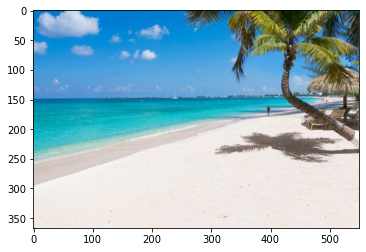

1. Calcula el gradiente vertical de la imágen


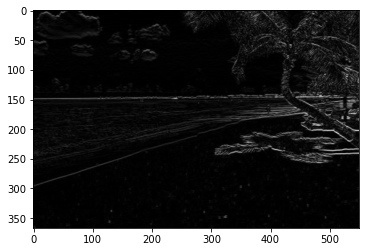

In [6]:
%matplotlib inline
## Carga la imágen en memória
print("0. Carga la imágen original")
im = plt.imread('img/beach.jpg')/255.
plt.imshow(im)
plt.show()

## Aplica un filtro de Sobel para calcular el gradiente
print("1. Calcula el gradiente vertical de la imágen")
dx = nd.sobel(rgb2gray(im), 0)
plt.imshow(np.abs(dx), cmap='gray')
plt.show()

Tendremos que encontrar el camino mínimo, es decir de la matriz de caminos tendremos que sacar un array que será el camino mínimo que buscamos. Se puede buscar un camino mínimo en horizontal o en vertical. En este caso lo haremos en vertical, tal como indica la imagen más arriba.

Cada elemento de la matriz de caminos es el índice del píxel anterior en el camino mínimo que estamos buscando, así que para referirnos al punto actual tendremos que restarle 1. 

Tendremos que buscar el elemento mínimo de y para cada x. Recorreremos todas las filas x, empezando por el final, yendo hacia atrás. En cada fila x buscaremos el mínimo de y. Guardaremos la posición (x, y) en una lista. Utilizaremos un bucle for para recorrer todas las filas. Para encontrar la y mínima de cada fila recurriremos a las funciones ya implementadas, top3, que te devuelve las 3 opciones posibles, y min_at, que te devuelve la mínima de las 3 opciones posibles.

Para poder modificar la posición de inicio de manera que en cada iteración trabajemos con una nueva posición los parámetros x e y de la posición los tendremos que poner en forma de listas. Pero en cambio una vez ya tenenemos las coordenadas que buscamos y queremos utilizarlas para modificar la imagen han de estar en formato de tupla. Para ello, trabajaremos con listas y cada vez que encontremos las posiciones para cada x las añadiremos a la lista donde guardaremos la solución en formato de tupla.

In [7]:
def min_at(arr, avoid=-1):
    assert len(arr.shape) == 1
    pos = 0
    mn = arr[0]
    for i in range(1, len(arr)):
        if (arr[i] < mn and arr[i] != avoid) or mn == avoid:
            mn = arr[i]
            pos = i
    return pos

def min_path_find(mat):
    # Dada la matriz de caminos, encuentra y devuelve el mínimo
    [x, y] = mat.shape
    # Dada la posición x (última) encontramos la y mínima
    point_ini = min_at(mat[x - 1,:])
    # la posición inicial será la última x y la correspondiente posición mínima
    posicion_inicio = [x - 1, point_ini]
    
    min_path = [tuple(posicion_inicio)]
    
    elemento = posicion_inicio
    for i in range(x - 1, 0, -1):
        top_elementos = top3(mat, elemento)
        minimo = min_at(top_elementos)
        elemento = [i ,(elemento[1]-1) + minimo]
        min_path.append(tuple(elemento))

    return min_path

def dynamic_programming(mat):
    # Crea una matriz del mismo tamaño que la matriz original
    ret = np.zeros(mat.shape)
    # x,y son el tamaño de la matriz original
    [x, y] = mat.shape
    
    """
    Se pueden utilizar las funciones importadas del archivo seam_carving_util.py que son:
    - top3: obtiene los tres elementos superiores de un punto en la matriz
    - min_at: obtiene la posición del elemento mas pequeño de un array
    
    Tu código aquí
    """
    # Construir la matriz de caminos
    for i in range(x):
        for j in range(y):
            if i == 0:
                ret[i][j] = mat[i][j]
            else:
                elementos = top3(ret,[i, j])
                minimo = min_at(elementos)
                ret[i][j] = mat[i][j] + elementos[minimo]
    
    return ret, min_path_find(ret)

2 y 3. Computo de todos los posibles caminos mínimos y búsqueda del mínimo definitivo.


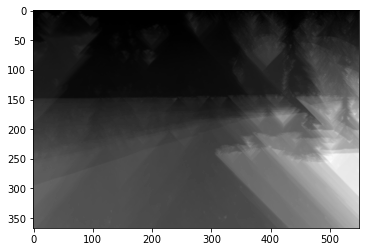

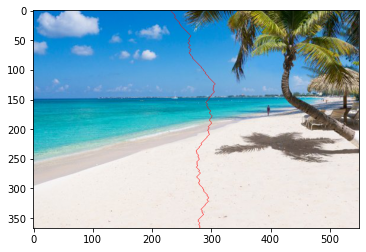

4. Elimina el camino mínimo


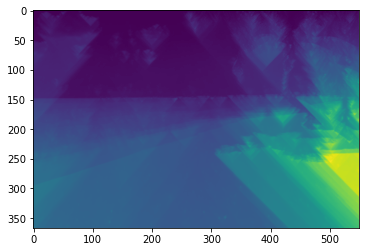

In [8]:
## Calcula la matriz de programación dinámica
print("2 y 3. Computo de todos los posibles caminos mínimos y búsqueda del mínimo definitivo.")
tmp, path = dynamic_programming(np.abs(dx))
plt.imshow(tmp, cmap='gray')
plt.show()

# Elimina el camino de la imágen y guardala en "updated"
updated = del_path(im, path)
# Muestra el camino eliminado sobre la imágen original
plt.imshow(mark_path(im, path))
plt.show()

# Elimina el camino
print("4. Elimina el camino mínimo")
new = del_path(tmp, path)
plt.imshow(new)
plt.show()

# Realiza los pasos anteriores de manera it

### 1.2 Eliminando zonas concretas de una imágen

Ahora suponed que, en lugar de eliminar el camino mínimo de una imágen queremos eliminar un elemento de la imagen sin que se note. Tomad como ejemplo las siguientes dos imágenes.

![](./img/agbar_a.png)
![](./img/agbar_b.jpg)

Alguna idea de como obtener este resultado?

<IPython.core.display.Javascript object>


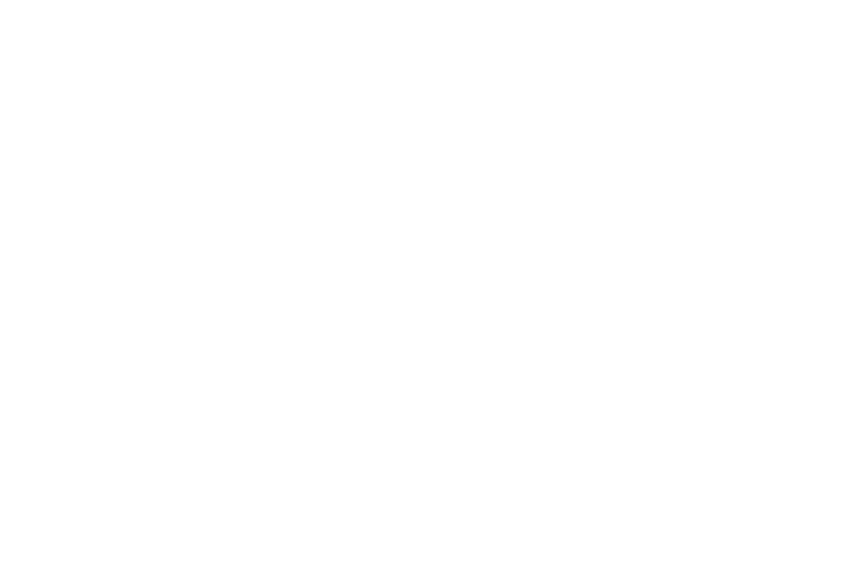

<IPython.core.display.Javascript object>


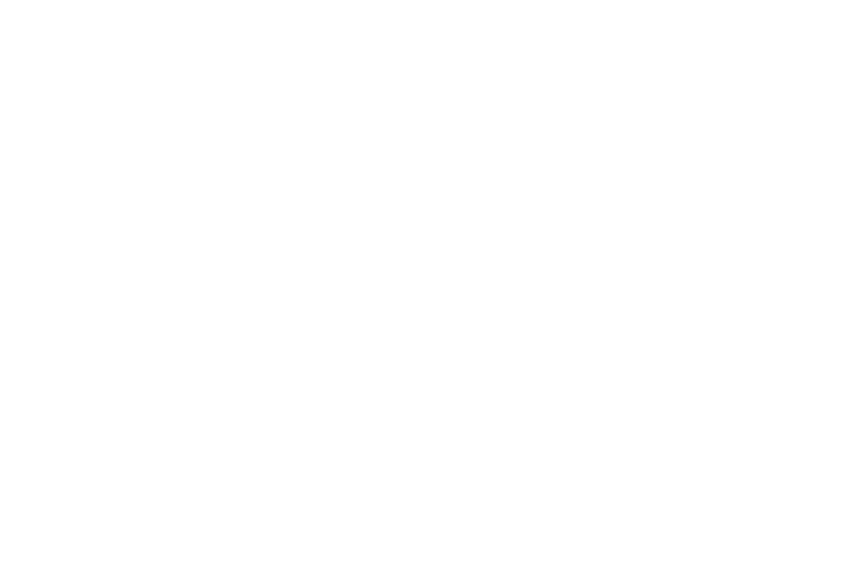

In [7]:
"""
Para que funcionen los siguientes bloques de código, es probable que tengáis que reiniciar el kernel.
Aquí obtenemos las coordenadas de una imágen obteniendo los clicks del usuario sobre esta.
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook

beach = plt.imread('./img/beach.jpg')
coords = []

def onclick(event):
    global ix, iy
    ix, iy = event.xdata, event.ydata
    print ('x = %d, y = %d'%(
        ix, iy))

    global coords
    coords.append((int(ix), int(iy)))

    if len(coords) == 2:
        fig.canvas.mpl_disconnect(cid)

    return coords


fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(beach)
cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [8]:
# Ahora le asignamos un peso a la imagen equivalente a 0 en cada uno de los puntos de dentro del cuadrado mínimo
print(coords)

def remove_pixels(img, coords):
    img.setflags(write=1)
    coords = [(min(coords[0][0], coords[1][0]), min(coords[0][1], coords[1][1])), 
              (max(coords[0][0], coords[1][0]), max(coords[0][1], coords[1][1]))]
    img[coords[0][1]:coords[1][1], coords[0][0]:coords[1][0], :] = 0
    return img


new =remove_pixels(beach, coords)
plt.figure()
plt.imshow(new)

[]


IndexError: list index out of range

In [9]:
def remove_object(img):
    img.setflags(write=1)
    y = img.shape[1]
    for i in range (y // 3):
        tmp, path = dynamic_programming(np.abs(dx))
        updated = del_path(img, path)
        new = del_path(tmp, path)
    return img


new =remove_object(beach)
plt.imshow(new)

NameError: name 'beach' is not defined

Con un blucle for encontramos una cantidad determinada de caminos mínimos y vamos eliminando los caminos hasta que hayamos eliminado un trozo de la imagen

<div class="alert alert-info">
<center>
  <h1>Entrega</h1>
</center>
<p>
La entrega de esta práctica (junto a la de greedy) se podrá realizar en el campus virtual hasta el día __25 de Noviembre a las 23:55__. En la tarea que se habilitará en el campus deberéis colgar __un archivo .zip__ que contenga __únicamente__ los notebooks de las dos prácticas siguiendo la siguiente nomenclatura:
</p>
<p>
```
*AA_P2_<apellido1>_<apellido2>_<nombre>.zip
|___* AA_PD_<apellido1>_<apellido2>_<nombre>.ipynb
|___* AA_Greedy_<apellido1>_<apellido2>_<nombre>.ipynb
```

</p>
<p>
Por ejemplo:
</p>
<p>
```
AA_P2_Doe_Ritchie_John.zip
```

</p>
<p>

Es fundamental que el código esté bién comentado y con un análisis de complejidad exhaustivo del algoritmo.También resulta de gran importancia que la entrega siga el formato indicado. 
</p>
</div>